In [3]:
# LSSVM

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sklearn import preprocessing

In [4]:
def get_columns_and_min_max(basepath, basename, sheetname, output_variable):
    # Get extra info from given data
    path = f"{basepath}\\{basename}.xlsx"
    data = pd.read_excel(path, sheet_name=sheetname)
    columns = squeeze_data(data.columns)
    df = data[output_variable]
    return data, list(columns), df.min(), df.max()


def split_dataset_by_fractions(data, basepath, basename, fractions):
    # Split input dataframe, data, by portions defined by the fractions
    df = pd.DataFrame(normalize_data([data])[0])
    df_rnd = df.sample(frac=1)
    fractions_cumulative = np.array(fractions)[:-1].cumsum()
    training, testing = np.split(
        df_rnd, (fractions_cumulative * len(df_rnd)).astype(int))
    training.columns, testing.columns = columns, columns
    dfs = {'training': training, 'testing': testing}
    for key in dfs.keys():
        path_out = f"{basepath}\\{basename}_{key}.xlsx"
        with pd.ExcelWriter(path_out) as writer:
            dfs[key].to_excel(writer, index=False, sheet_name=key)


def train_lssvm_model(x_train, y_train, gamma, sigma):
    length = np.shape(x_train)[0]
    pattern = calculate_similarity(x_train, x_train, sigma)

    # Add gamma to generalize prediction and prevent overfitting issues
    innerMatrix = pattern + np.identity(length) * (1 / gamma)

    # Prepare matrix parts
    leftOnes = np.mat(np.ones((length, 1)))  # [[1][1][1][etc]]
    zeroEntry = np.mat(np.zeros((1, 1)))  # [[0]]
    topOnes = leftOnes.T  # [[1 1 1 etc]]

    # Create final matrices
    topPart = np.hstack((zeroEntry, topOnes))
    botPart = np.hstack((leftOnes, innerMatrix))
    matrix = np.vstack((topPart, botPart))
    solution = np.vstack((zeroEntry, y_train))

    # Calculate bias and alpha values
    b_alpha = matrix.I * solution  # Inverse matrix imprinted on solution vector form
    b = b_alpha[0, 0]
    alphas = b_alpha[1:, 0]

    return alphas, b


def calculate_similarity(x_ref, x_check, sigma):
    # Compares new and reference data, for all combinations of data rows
    rows, columns = np.shape(x_ref)[0], np.shape(x_check)[0]
    pattern = np.mat(np.zeros((rows, columns)))
    for column, item in enumerate(x_check):
        for row, reference_item in enumerate(x_ref):
            pattern[row, column] = kernel(v1=item, v2=reference_item)
    return pattern


def kernel(v1, v2):
    # Kernel -> Quantifies how equal one (input) row of data is to another (input) row
    deltaRow = squeeze_data(v1 - v2)
    temp = np.dot(deltaRow, deltaRow)
    kernel = np.exp(temp / (-1 * sigma ** 2))
    return kernel


def predict(x_ref, x_check, alphas, b, sigma):
    # Predicts unknown values using known model values (=alphas and bias)
    pattern = calculate_similarity(x_ref, x_check, sigma)
    columns = np.shape(pattern)[1]
    prediction = np.mat(np.zeros((columns, 1)))
    for row_index, column_index in enumerate(range(columns)):
        pattern_column = squeeze_data(pattern[:, column_index])
        prediction[row_index] = np.dot(pattern_column, alphas) + b
    return prediction


def squeeze_data(data):
    # Convert from matrix to array form
    data_array = np.squeeze(np.asarray(data))
    return data_array


def normalize_data(data):
    # Normalize data based on its min and max values
    scalar = preprocessing.MinMaxScaler()
    result = []
    for item in data:
        norm = scalar.fit_transform(item)
        result.append(norm)
    return result


def lookup_real_value(xmin, xmax, x):
    # Find equivalent real values from normalized values
    result = []
    for norm in x:
        real = xmin + norm * (xmax - xmin)
        result.append(real)
    return result


In [7]:
base_path = os.path.dirname(os.path.realpath("housing_data.xlsx"))

# File options
use_complex_data = 'no'
split_and_export_data = 'yes'
plot_real_values = 'yes'

# Select data
filename, sheetname, output_column_name = "", "", ""
if use_complex_data == 'yes':
    filename, sheetname, output_column_name = "housing_data", "Boston Housing 80's", "MEDV"
else:
    filename, sheetname, output_column_name = "simple_data", "Simple Line", "Rain amount"

In [9]:
# Get data, columns, and ymin and ymax to later de-normalize the (predicted) output data
data, columns, ymin, ymax = get_columns_and_min_max(
    base_path, filename, sheetname, output_column_name)

# Change the below option to turn off or on export of split data
if split_and_export_data == 'yes':
    fractions = [0.80, 0.20]
    split_dataset_by_fractions(data, base_path, filename, fractions)

# Training data (80 %)
file_name_training = f"{filename}_training"
path_to_file = f"{base_path}\\{file_name_training}.xlsx"
dftrain = pd.read_excel(path_to_file)

# Testing data (20 %)
file_name_testing = f"{filename}_testing"
path_to_file = f"{base_path}\\{file_name_testing}.xlsx"
dftest = pd.read_excel(path_to_file)

# Prepare normalized data
# Pop output column out of list
output_column = columns.pop(columns.index(output_column_name))
xtrain_norm, ytrain_norm = np.mat(
    dftrain[columns]), np.mat(dftrain[output_column]).T
xtest_norm, ytest_norm = np.mat(
    dftest[columns]), np.mat(dftest[output_column]).T

# LSSVM - Optimization Parameters
gamma, sigma = 10, 1

# LSSVM - training the model
alphas, bias = train_lssvm_model(xtrain_norm, ytrain_norm, gamma, sigma)

# LSSVM - using model to predict (validate) the trained model
prediction = predict(xtrain_norm, xtrain_norm, alphas, bias, sigma)

# LSSVM - using model to predict (testing) the trained model on new data
prediction_test = predict(xtrain_norm, np.mat(xtest_norm), alphas, bias, sigma)

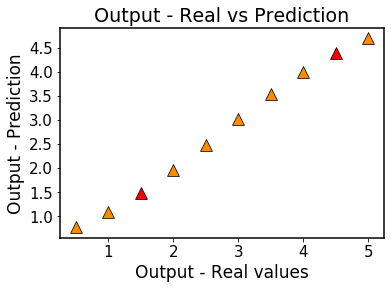

In [10]:
# Plot settings
mpl.rcParams['axes.linewidth'] = 1.5
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)


def set_plot_settings():
    plt.title("Output - Real vs Prediction", fontsize=19, color='black')
    plt.xlabel("Output - Real values", fontsize=17, color='black')
    plt.ylabel("Output - Prediction", fontsize=17, color='black')
    plt.xticks(fontsize=15, color='black')
    plt.yticks(fontsize=15, color='black')


# Standardize y values
ytrain, ytest = ytrain_norm, ytest_norm

# Plot as normalized or real values
filename_extra = ""
if plot_real_values == 'yes':
    filename_extra = "real_values"
    ytrain = lookup_real_value(ymin, ymax, squeeze_data(ytrain))
    ytest = lookup_real_value(ymin, ymax, squeeze_data(ytest))
    prediction = lookup_real_value(ymin, ymax, squeeze_data(prediction))
    prediction_test = lookup_real_value(
        ymin, ymax, squeeze_data(prediction_test))

# Note: A straight line trend = Good prediction quality of LSSVM model

# Plot output vs prediction (training)
plt.scatter(squeeze_data(ytrain), squeeze_data(prediction), marker='^', s=140,
            facecolors='darkorange', edgecolors='black', linewidths=0.75)
set_plot_settings()
savefig(f'{base_path}\\{file_name_training}_{filename_extra}.png',
        transparent=False)
plt.cla()

# Plot output vs prediction (testing)
plt.scatter(squeeze_data(ytest), squeeze_data(prediction_test), marker='^', s=140,
            facecolors='red', edgecolors='black', linewidths=0.75)
set_plot_settings()
savefig(f'{base_path}\\{file_name_testing}_{filename_extra}.png',
        transparent=False)
plt.cla()

# Plot output vs prediction (combined)
plt.scatter(squeeze_data(ytrain), squeeze_data(prediction), marker='^', s=140,
            facecolors='darkorange', edgecolors='black', linewidths=0.75)
plt.scatter(squeeze_data(ytest), squeeze_data(prediction_test), marker='^', s=140,
            facecolors='red', edgecolors='black', linewidths=0.75)
set_plot_settings()
savefig(f'{base_path}\\{filename}_combined_{filename_extra}.png',
        transparent=False)

plt.show()